In [1]:
import os#
#os.chdir('c:\\Users\\ma11115\\OneDrive - Imperial College London\\github_folder\\STK_SEARCH\\')
os.chdir("/rds/general/user/ma11115/home/STK_Search/STK_search")
from pathlib import Path#
import pandas as pd
import torch
import numpy as np
import importlib
from stk_search.utils import database_utils

os.makedirs('data/output/search_experiment/search_exp_database', exist_ok=True)

In [9]:
# run a search experiment with the new target
from stk_search.utils import run_hpc_utils
importlib.reload(run_hpc_utils)
df_total_path_bench = 'data/output/Full_dataset/30K_benchmark_150524.csv'
df_precursors_path ="data/output/Prescursor_data/precursor_data_new_clustering.pkl"
df_precursor_Mordred_path="data/output/Prescursor_data/df_PCA_mordred_descriptor_290224.pkl"

search_space_loc = "data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl"#"data/input/EXP_search_space/6_frag_all_2024_05_11_22_40_37//search_space_0.pkl"

In [3]:
# load and check the search space
from stk_search import Search_space
search_space = pd.read_pickle(search_space_loc)
print(' Search space condition list:', search_space.conditions_list)
print('shape of df_precursors:', search_space.df_precursors.shape)
print('search space syntax:', search_space.syntax)


 Search space condition list: [[], [], [], [], [], []]
shape of df_precursors: (274, 49)
search space syntax: [0, 1, 2, 3, 4, 5]


In [4]:
# load and check the dataframe to search over and the df_precursors
df_Benchmark , df_precursors= database_utils.load_data_from_file(df_total_path_bench, df_precursor_path,add_feature_frag=True)
df_precursor_Mordred = pd.read_pickle(df_precursor_Mordred_path)
print('shape of df_Benchmark:', df_Benchmark.shape)
print('shape of df_precursors:', df_precursors.shape)
print('shape of df_precursor_Mordred:', df_precursor_Mordred.shape)
print(df_Benchmark[df_Benchmark['target']>0].shape[0]/df_Benchmark.shape[0])

shape of df_Benchmark: (30000, 207)
shape of df_precursors: (306, 40)
shape of df_precursor_Mordred: (312, 101)
0.0111


In [5]:
num_of_elem_in_SP = search_space.check_df_for_element_from_SP(df_Benchmark).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)

number of elements in the benchmark in the search space: (30000, 207)


In [6]:
# set the benchmark parameters  
exp_name = "Benchmark_30K_dataset_full"
num_elem_initialisation=300
num_iteration=500
target = 'target'
aim = 'maximise'
case_name_list = ["ea_surrogate_new", "BO_learned_new",'evolution_algorithm','random','BO_precursor'] # ['evolution_algorithm','random','BO_precursor']#,["ea_surrogate_new", "BO_learned_new"] # "ea_surrogate", "BO_learned"
config_dir_list = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240322/SchNet/splitrand-nummol50000"]
config_dir_list_new = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240412/SchNet/splitrand-nummol68864"]
config_dir_list_new = ["/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/"]#f"/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240513/SchNet/splitrand-nummol{num_mol}" for num_mol in [10000,20000,30000,40000,50000]]

In [10]:
importlib.reload(run_hpc_utils)

def run_search_on_hpc(
    case_name="ea_surrogate",
    df_path_total=df_total_path_bench,
    df_precursors_path=df_precursor_path,
    frag_properties="selected",
    config_dir="",
    dataset_representation_path = None,
    test=False,
    lim_counter = 5,
    which_acquisition = "EI",

):
    string_to_run_notebook, script_qsub = run_hpc_utils.generate_string_run(
        case=case_name,
        target=target,
        aim=aim,
        num_elem_initialisation=num_elem_initialisation,
        num_iteration=num_iteration,
        df_path=df_path_total,
        benchmark=False,
        test_name=exp_name,
        df_precursors_path=df_precursors_path,
        frag_properties=frag_properties,
        config_dir=config_dir,
        dataset_representation_path=dataset_representation_path,
        lim_counter = lim_counter,
        which_acquisition = which_acquisition,
        search_space_loc = search_space_loc,
    )
    if test:
        %run {string_to_run_notebook}
        return string_to_run_notebook
    run_hpc_utils.submit_job(script_qsub, case_name)




In [11]:
for case_name in case_name_list:
    if case_name == 'ea_surrogate' or case_name == "BO_learned":
        for config_dir in config_dir_list:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir = config_dir,
            )
    elif case_name == 'ea_surrogate_new' or case_name == "BO_learned_new":
        for config_dir in config_dir_list_new:
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_path,
                frag_properties="selected",
                config_dir = config_dir,
            )
    else:
        run_search_on_hpc(
            case_name=case_name,
            df_precursors_path=df_precursor_path,
            frag_properties="selected",
        )
        if case_name =='BO_precursor':
            run_search_on_hpc(
                case_name=case_name,
                df_precursors_path=df_precursor_Mordred_path,
                frag_properties="all",
        )

src/dev_scripts/run_search_new.py  --case ea_surrogate_new --test_name Benchmark_30K_dataset_full --target target --aim maximise --num_iteration 500 --num_elem_initialisation 300 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv --df_precursors_path data/output/Prescursor_data/precursor_data_200324.pkl --config_dir /rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/ --search_space_loc data/input/EXP_search_space/6_mers_filtered_BB_2024_05_15_09_28_21//search_space_0.pkl --frag_properties selected --lim_counter 5
9436688[].pbs
src/dev_scripts/run_search_new.py  --case BO_learned_new --test_name Benchmark_30K_dataset_full --target target --aim maximise --num_iteration 500 --num_elem_initialisation 300 --which_acquisition EI --dataset_representation_path None --df_path data/output/Full_dataset/30K_benchmark_150524.csv --df_precursors_path da

## analyse results

In [15]:
## load data from the database
from stk_search import Searched_space
from stk_search.utils import database_utils

df_total_new , df_precursors= database_utils.load_data_database(df_precursors_path,num_fragm=6)

/rds/general/user/ma11115/home/STK_Search/STK_search/src/stk_search/utils/database_utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f"InChIKey_{i}"] = df_test["BB"].apply(


In [16]:
num_of_elem_in_SP = search_space.check_df_for_element_from_SP(df_total_new).shape
print('number of elements in the benchmark in the search space:', num_of_elem_in_SP)
print('number of elements in new datafrage:', df_total_new.shape)

number of elements in the benchmark in the search space: (43354, 28)
number of elements in new datafrage: (43354, 28)


In [18]:

import glob
import pickle
import json
def load_search_list(df):
    search_list = []
    for index, row in df.iterrows():
        search_list.append(pickle.load(open(row['search_exp_file'], "rb")))
    return search_list
save_path = f"data/output/search_experiment/search_exp_database"
json_files = glob.glob(f"{save_path}/*.json")
list_json = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        list_json.append(json.load(f))
    f.close()
df = pd.DataFrame(list_json)
df['search_exp_file'] = df['search_output_folder']+"/"+df['date']+"/results_"+df['run_search_name']+'.pkl'
df = df[~df['benchmark']]
print(df.shape)
df_all = df.copy()
df_all.head()


(702, 21)


,num_iteration,num_elem_initialisation,test_name,case,target_name,config_dir,aim,which_acquisition,lim_counter,search_space_loc,...,df_path,df_precursors_path,benchmark,dataset_representation_path,frag_properties,run_search_name,search_output_folder,date,git_version,search_exp_file
8,1000,300,new_target,BO_learned,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,3,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,data/output/Prescursor_data/calculation_data_p...,False,/rds/general/user/ma11115/home/STK_Search/STK_...,all,03a6fc5b7f1e487c99616de87a3cc903,data/output/search_experiment/6_frag/new_target,20240403,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/new_targe...
13,1000,300,new_target,ea_surrogate,target,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,data/output/Prescursor_data/calculation_data_p...,False,/rds/general/ephemeral/user/ma11115/ephemeral/...,all,7adfde07233e439db430bf085ef2065c,data/output/search_experiment/6_frag/new_target,20240327,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/new_targe...
14,1000,300,new_target,BO_precursor,target,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,/rds/general/user/ma11115/home/STK_Search/STK_...,False,,selected,968543ae1dfd44deb66b5e9ab6a95b61,data/output/search_experiment/6_frag/new_target,20240325,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/new_targe...
18,1000,300,new_target,random,target,/rds/general/user/ma11115/home/Geom3D/Geom3D/t...,None,EI,10,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,/rds/general/user/ma11115/home/STK_Search/STK_...,False,,selected,91af53b46a77466a92b1c0478b8b6be0,data/output/search_experiment/6_frag/new_target,20240325,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/new_targe...
20,1000,300,test_new_representtion,ea_surrogate_new,maximise,/rds/general/user/ma11115/home/STK_Search/STK_...,None,EI,3,/rds/general/user/ma11115/home/STK_Search/STK_...,...,/rds/general/user/ma11115/home/STK_Search/STK_...,data/output/Prescursor_data/calculation_data_p...,False,,all,6edeaf916f574ed9bb019cde31e66029,data/output/search_experiment/6_frag/test_new_...,20240429,e5c60ca4e136ee47e25bbaa7e455f565895b70c3,data/output/search_experiment/6_frag/test_new_...


In [23]:

oligomer_size = 6 
test_names = ['Benchmark_30K_dataset_full']

df_filtered = df_all[df_all['oligomer_size']==oligomer_size]
df_filtered = df_filtered[df_filtered['test_name'].isin(test_names)]
print(df_filtered.shape)

print(df_filtered.shape)
df_list = df_filtered.groupby(['case','frag_properties','which_acquisition','config_dir','df_path','df_precursors_path','test_name'])
print(len(df_list))
df_list.describe()

(49, 21)
(49, 21)
1


num_iteration  \
                                                                                                                                                                                                                                              count   
case             frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                 test_name                                  
ea_surrogate_new selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full          49.0   

                                                                                                                                                                                                                                              \
                                                                                                                                                                                                                                        mean   
case             frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                 test_name                           
ea_surrogate_new selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full  500.0   

                                                                                                                                                                                                                                            \
                                                                                                                                                                                                                                       std   
case             frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                 test_name                         
ea_surrogate_new selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full  0.0   

                                                                                                                                                                                                                                              \
                                                                                                                                                                                                                                         min   
case             frag_properties which_acquisition config_dir                                         df_path                                           df_precursors_path                                 test_name                           
ea_surrogate_new selected        EI                /rds/general/user/ma11115/home/STK_Search/STK_s... data/output/Full_dataset/30K_benchmark_150524.csv data/output/Prescursor_data/precursor_data_2003... Benchmark_30K_dataset_full  500.0   

                                                                                                                                                                                                                                              \
                                                                                                                              

In [48]:
import pandas as pd
def join_name(x):
    return '*'.join(x)

def load_search_list(df,min_num_iteration):
    search_list = []
    for index, row in df.iterrows():
        if min_num_iteration <= row['max_num_eval']:
            search_list.append(pd.read_pickle(row['search_exp_file']))
    return search_list
def get_results_length(x):
    try:
        return len(pd.read_pickle(x)['fitness_acquired'])
    except Exception as e:
        #print(e)
        return 0
results_dict = {}
num_searches_with_min, df_plot_dict = {}, {}
min_num_iteration = 300
max_num_iteration = 500
for name , df in df_list:
    if len(df) != 0: 
        df['max_num_eval']=df['search_exp_file'].apply(lambda x: get_results_length(x))
        key = join_name(name)
        df['key'] = key
        if df['max_num_eval'].max() >= min_num_iteration:
            results_dict[key] = load_search_list(df,min_num_iteration)
            num_searches_with_min[key] = (len(results_dict[key]), df['df_path'].values[0])
df_summary_1 = pd.DataFrame.from_dict(num_searches_with_min, orient='index',columns=['number of explorations with min iterations','df_path'])
df_summary_1['key'] = df_summary_1.index    
df_summary_1['case'] = df_summary_1['key'].apply(lambda x: x.split('*')[0])
df_summary_1['num_mol_training'] = df_summary_1['key'].apply(lambda x: x.split('nummol')[-1])

df_summary_1['which_acquisition'] = df_summary_1['key'].apply(lambda x: x.split('*')[2])
df_summary_1['test_name'] = df_summary_1['key'].apply(lambda x: x.split('*')[-1])
df_summary_1.reset_index(inplace=True)
df_summary_1

,index,number of explorations with min iterations,df_path,key,case,num_mol_training,which_acquisition,test_name
0,ea_surrogate_new*selected*EI*/rds/general/user...,49,data/output/Full_dataset/30K_benchmark_150524.csv,ea_surrogate_new*selected*EI*/rds/general/user...,ea_surrogate_new,20000/*data/output/Full_dataset/30K_benchmark_...,EI,Benchmark_30K_dataset_full


In [28]:
import datetime
import pickle
from stk_search.utils import Search_results_plot
from stk_search.utils import plot_results_all
import importlib
importlib.reload(Search_results_plot)
importlib.reload(plot_results_all)
save_folder = '/rds/general/user/ma11115/home/STK_Search/STK_search/data/figures/'+datetime.datetime.now().strftime("_%Y_%m_%d")
plot_function_list_single = [Search_results_plot.plot_simple_regret,Search_results_plot.plot_cumulative_regret,
                      Search_results_plot.plot_number_of_molecule_discovered,Search_results_plot.plot_rate_of_discovery,]
plot_function_list_multi = [Search_results_plot.plot_all_y_max,Search_results_plot.plot_number_of_molecule_discovered_sum,Search_results_plot.plot_total_rate_of_discovery, ]

 keys : 0    ea_surrogate_new*selected*EI*/rds/general/user...
Name: key, dtype: object


 number of new calculations 678  number of new oligomers in top  341  for key  ea_surrogate_new*selected*EI*/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240516//SchNet/splitrand-nummol20000/*data/output/Full_dataset/30K_benchmark_150524.csv*data/output/Prescursor_data/precursor_data_200324.pkl*Benchmark_30K_dataset_full


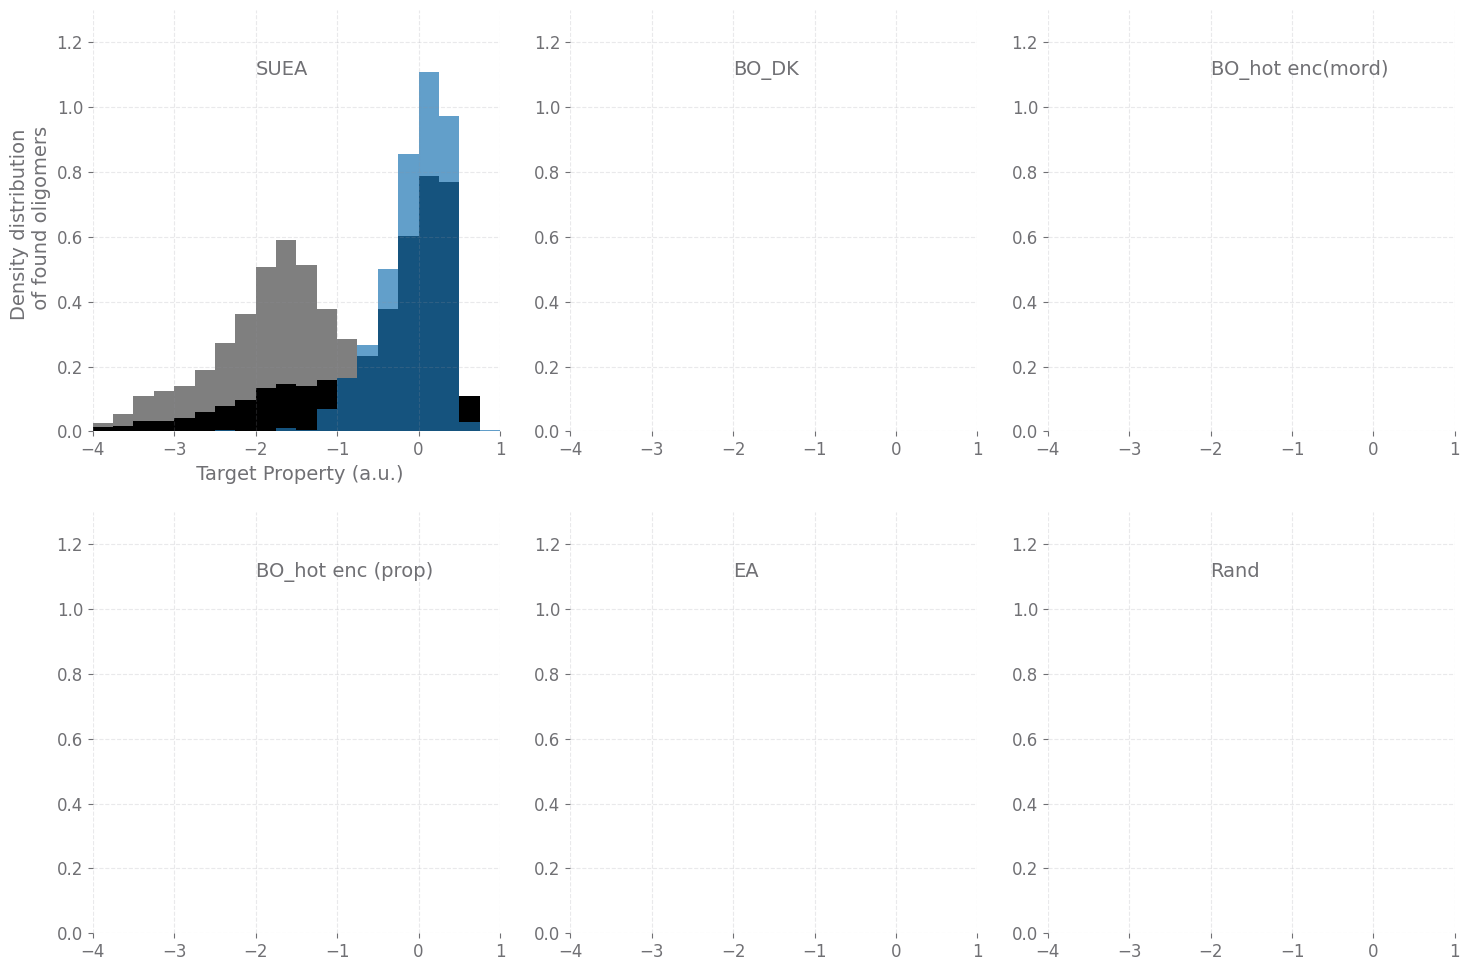

In [72]:
#df_mol_dict = plot_results_all.load_mol_dict()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_plot = df_summary_1.copy()
#df_plot = df_plot.iloc[[0,2,3,4,6,7]]
#legend_list = ['BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','SU EA','EA','Rand']
df_plot = df_plot
legend_list = ['SUEA', 'BO_DK','BO_hot enc(mord)','BO_hot enc (prop)','EA','Rand']
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax= ax.flatten()
color_list = sns.color_palette("tab10", len(df_plot))
df_plot["color"] = color_list
df_max_found_dict = {}
df_results_dict = {}
keys = df_plot["key"]
print(" keys :", keys)
min_target = df_Benchmark[target].iloc[int(df_Benchmark.shape[0]*0.01)]
range_res = (-4,1)


for i,key in enumerate(keys.values):
    res = results_dict[key]
    color = df_plot[df_plot["key"] == key]["color"].iloc[0]


    metric_dict = {}


    df_results, df_max_found = Search_results_plot.get_df_max_target_found(
        res,
        max_iteration=500,
        df_total=df_total_new,
        num_initialisation=300,
        target_name=target,

        min_target=min_target,
    )

    df_results_new = df_results[~df_results['InChIKey'].isin(df_Benchmark['InChIKey'])]
    df_max_found = df_max_found[~df_max_found['InChIKey'].isin(df_Benchmark['InChIKey'])]
    df_total_new_new = df_total_new[~df_total_new['InChIKey'].isin(df_Benchmark['InChIKey'])]
    df_Benchmark.hist(target,bins=20,ax=ax[i],color='black',alpha=0.5,range=range_res,density= True)
    df_total_new_new.hist(target,bins=20,ax=ax[i],color='black',alpha=1,range=range_res,density= True)


    df_results_new.hist(target,bins=20,ax=ax[i],label=key,color=color,alpha=0.7,range=range_res,density= True)
    df_max_found_dict[key] = df_max_found
    df_results_dict[key] = df_results
    print(' number of new calculations',df_results_new.shape[0],' number of new oligomers in top ',df_max_found.shape[0],' for key ',key)
    #print('rate of discovery', df_max_found.shape[0]/df_results.shape[0])

    ax[i].set_ylabel("Density distribution \n of found oligomers")
    ax[i].set_xlabel(' Target Property (a.u.)')

    ax[i].set_title('')
    #ax[i].set_ylim(0,1100)
    

fig.tight_layout()
for i in range(len(legend_list)):
    ax[i].set_xlim(-4,1)
    ax[i].set_ylim(0,1.3)
    ax[i].text(-2,1.1,legend_list[i])



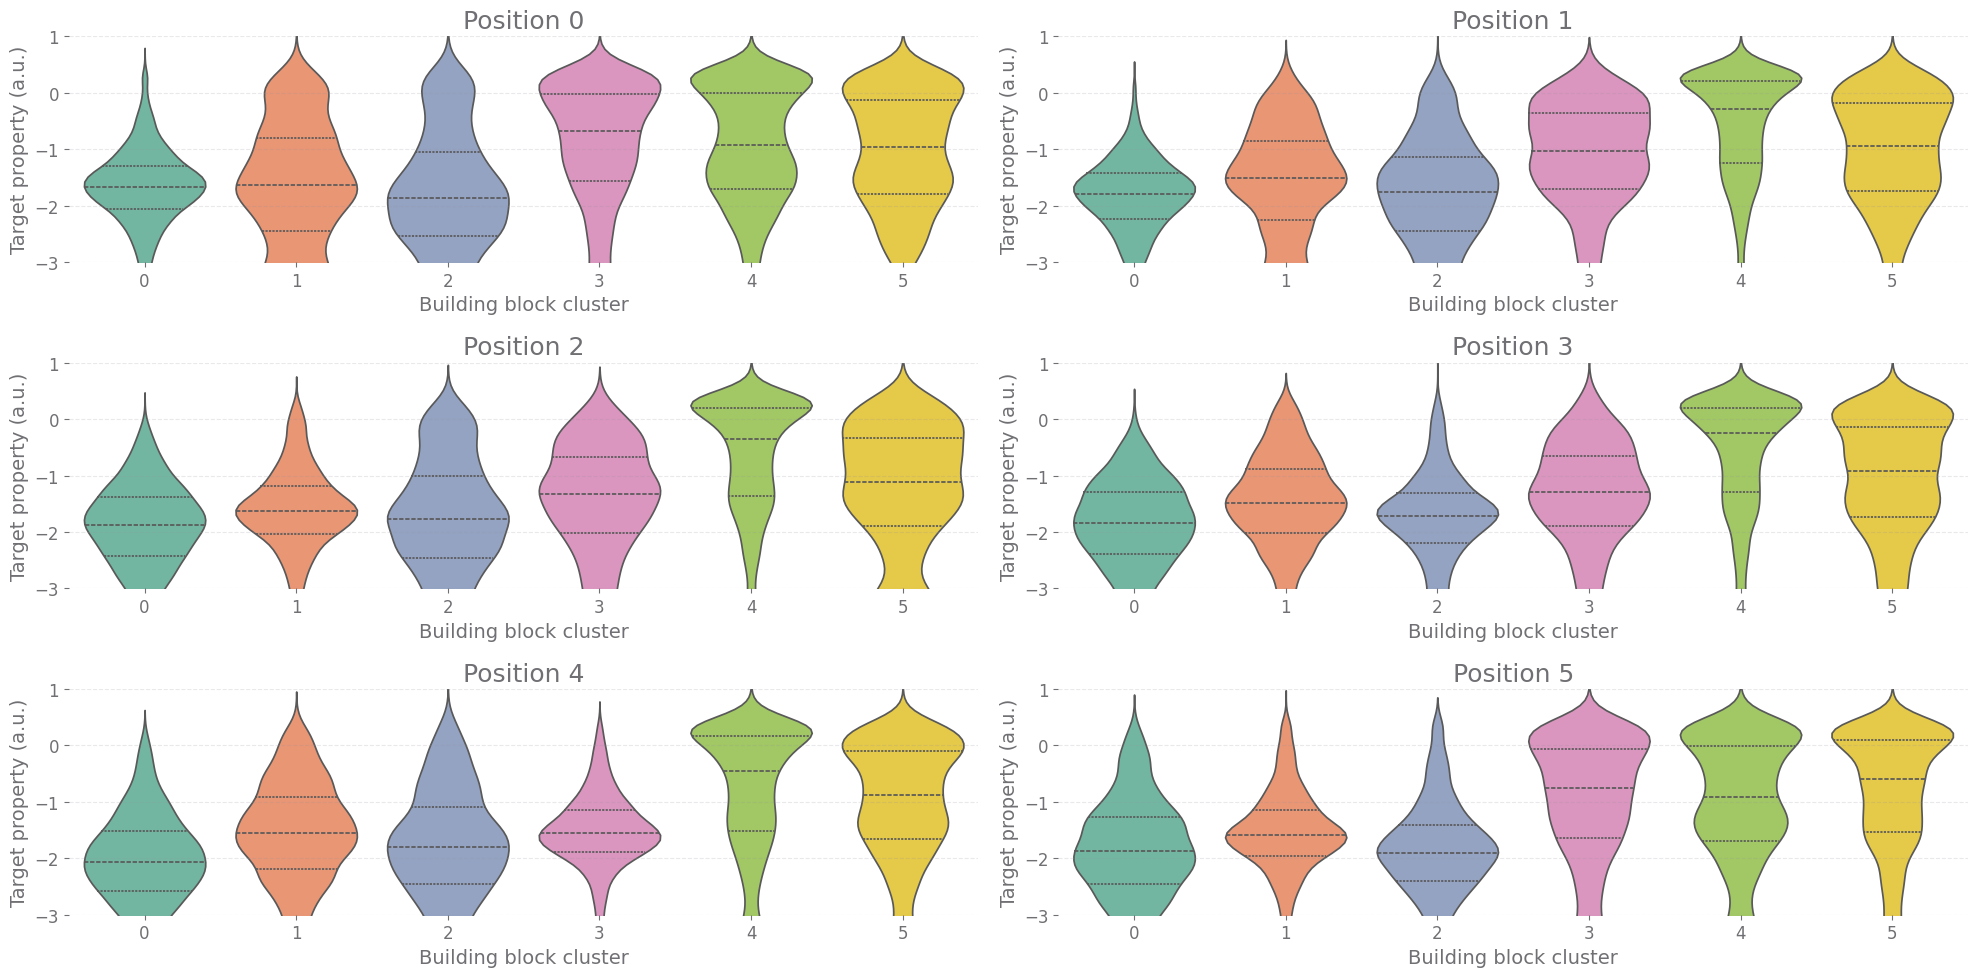

In [64]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
def plot_violin_cluster (df):
    df_plot = df.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
    import seaborn as sns
    fig,ax = plt.subplots(3,2,figsize=(20,10))
    ax=ax.flatten()
    for i,_ax in enumerate(ax[:6]):
        sns.violinplot(data=df_plot, x=f'cluster_{i}', y="target", split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
        _ax.set_ylim(-3,1)
        _ax.legend().set_visible(False)
        _ax.set_title(f'Position {i}')
        _ax.set_xlabel(f'Building block cluster')
        _ax.set_ylabel(f'Target property (a.u.)')
    fig.tight_layout()

plot_violin_cluster(df_total_new)

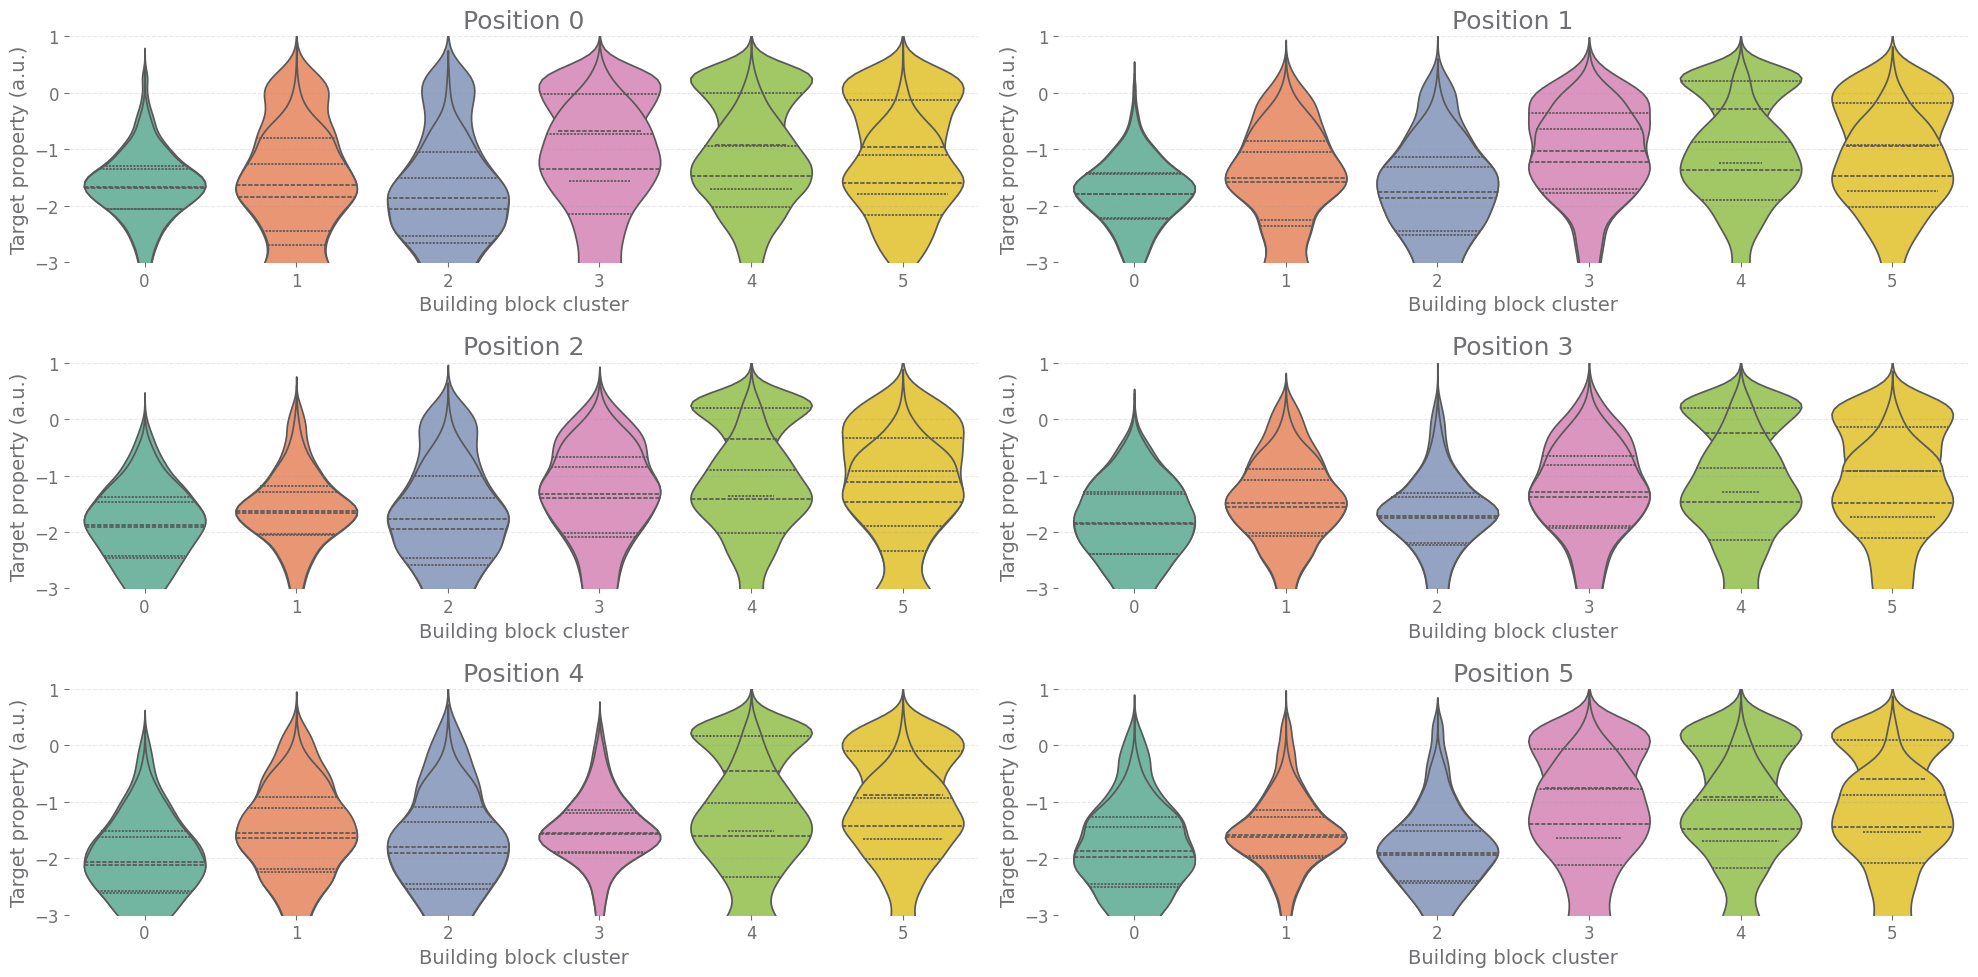

In [68]:
df_prec_cluster = df_precursors[['InChIKey','cluster']].copy()
df_prec_cluster['InChIKey_precursor'] = df_prec_cluster['InChIKey']
df_prec_cluster.drop('InChIKey',axis=1,inplace=True)
import seaborn as sns
def plot_violin_cluster_compare (df,df2):
    df_plot = df.copy()
    df_plot_2 = df2.copy()
    for i in range(6):
        df_plot['InChIKey_precursor'] = df_plot[f'InChIKey_{i}']
        df_plot = df_plot.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot[f'cluster_{i}'] = df_plot['cluster']
        df_plot.drop('cluster',axis=1,inplace=True)
        df_plot_2['InChIKey_precursor'] = df_plot_2[f'InChIKey_{i}']
        df_plot_2 = df_plot_2.merge(df_prec_cluster,how='left',on='InChIKey_precursor',suffixes=('',f'_{i}') )
        df_plot_2[f'cluster_{i}'] = df_plot_2['cluster']
        df_plot_2.drop('cluster',axis=1,inplace=True)
    fig,ax = plt.subplots(3,2,figsize=(20,10))
    ax=ax.flatten()
    for i,_ax in enumerate(ax[:6]):
        sns.violinplot(data=df_plot, x=f'cluster_{i}', y="target", split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
        sns.violinplot(data=df_plot_2, x=f'cluster_{i}', y="target", split=False, inner="quart",ax=_ax,hue=f'cluster_{i}',palette='Set2')
        _ax.set_ylim(-3,1)
        _ax.legend().set_visible(False)
        _ax.set_title(f'Position {i}')
        _ax.set_xlabel(f'Building block cluster')
        _ax.set_ylabel(f'Target property (a.u.)')
    fig.tight_layout()

plot_violin_cluster_compare(df_total_new,df_Benchmark)